# Using various classifiers on the red wine dataset

On this notebook we attempt to test different classifiers on the popular [red wine dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?datasetId=4458&sortBy=voteCount).

## Columns description

1. **fixed acidity**: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. **volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. **citric acid**: found in small quantities, citric acid can add 'freshness' and flavor to wines
4. **residual sugar**: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter
5. **chlorides**: the amount of salt in the wine
6. **free sulfur dioxide**: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents
7. **total sulfur dioxide**: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2
8. **density**: the density of water is close to that of water depending on the percent alcohol and sugar content
9. **ph**: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4
10. **sulphates**: a wine additive which can contribute to sulfur dioxide gas (S02) levels, which acts as an antimicrobial
11. **alcohol sulfur dioxide**: the percent alcohol content of the wine
12. **quality**: output variable (based on sensory data, score between 0 and 10) 

### Imports and directories to save results

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import norm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from keras.layers import Input, Dense
from keras.models import Model

In [2]:
warnings.filterwarnings("ignore")

np.random.seed(42)

save = True

sns.set_palette("muted")

if save:
    os.makedirs("figures/", exist_ok = True)
    os.makedirs("tables/", exist_ok = True)

---

### The dataset

In [3]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
rows, columns = df.shape
print(f"There are {rows} rows and {columns} columns")

There are 1599 rows and 12 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


There are no missing values or categorical features. Every feature is float and *quality* is int

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the discrepancy between *min* and *max* values we can expect a lot of outliers in this dataset

---

### Data analysis

In [7]:
quality_counts = df.groupby("quality").quality.count()
quality_counts

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

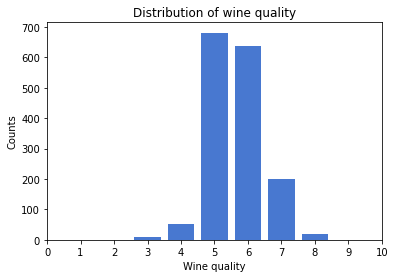

In [8]:
plt.bar(x = quality_counts.index, height=quality_counts.values)
plt.xlabel("Wine quality")
plt.ylabel("Counts")
plt.xticks(np.arange(0, 11))
plt.title("Distribution of wine quality")
plt.savefig("figures/wine_quality_distribution.jpeg", bbox_inches="tight") if save else plt.show()

From this bar plot we can see that this dataset is highly unbalanced with quality 5 and 6 having a lot more examples than the others and quality 0, 1, 2, 9 and 10 not having examples at all.<br>
This is a problem that we will deal with later on

Now, for each feature, we are going to present:
1. histogram with the density function plotted against the normal density function
2. bar plot of how each feature influences the quality of the wine
3. finally, a box-plot to verify if there are outliers

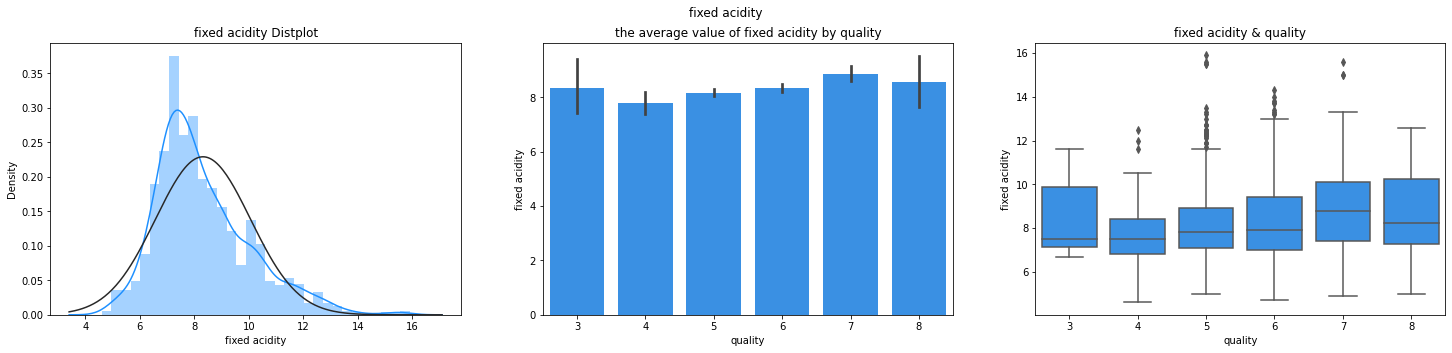

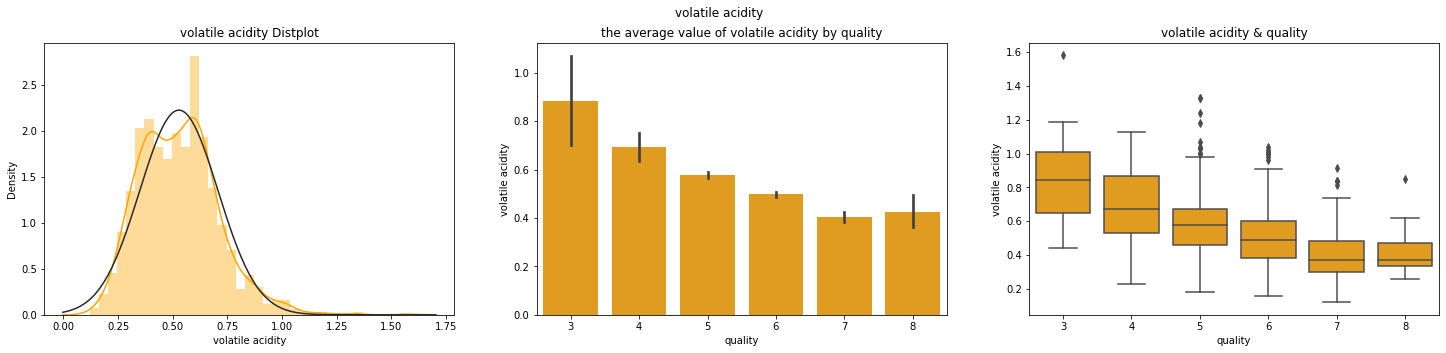

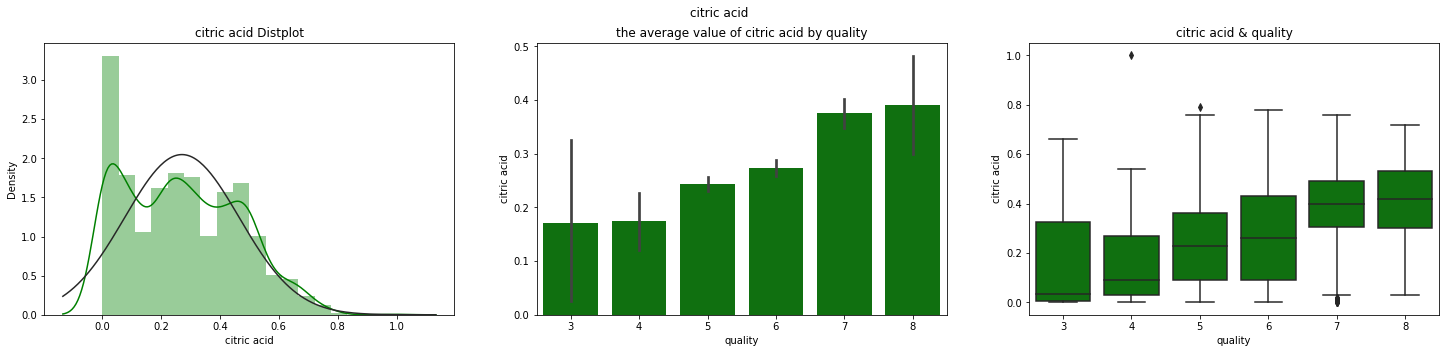

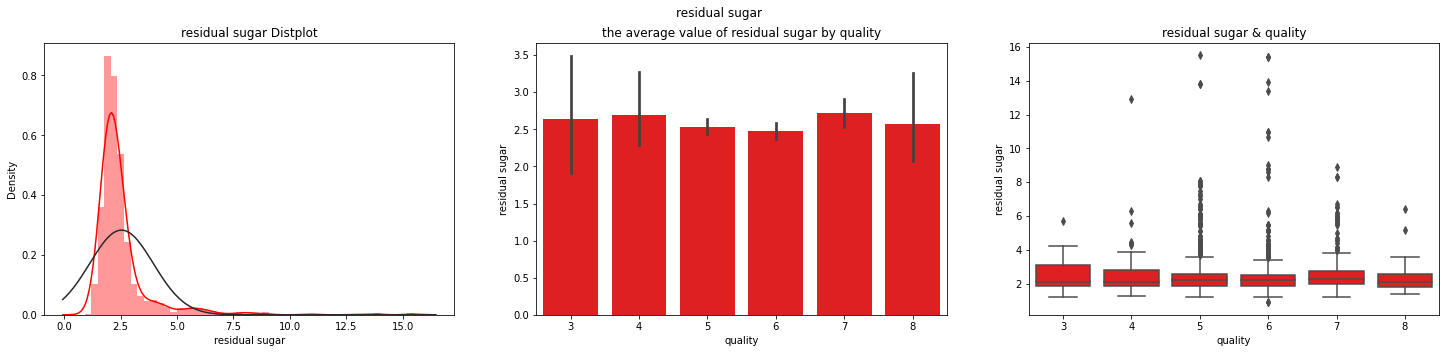

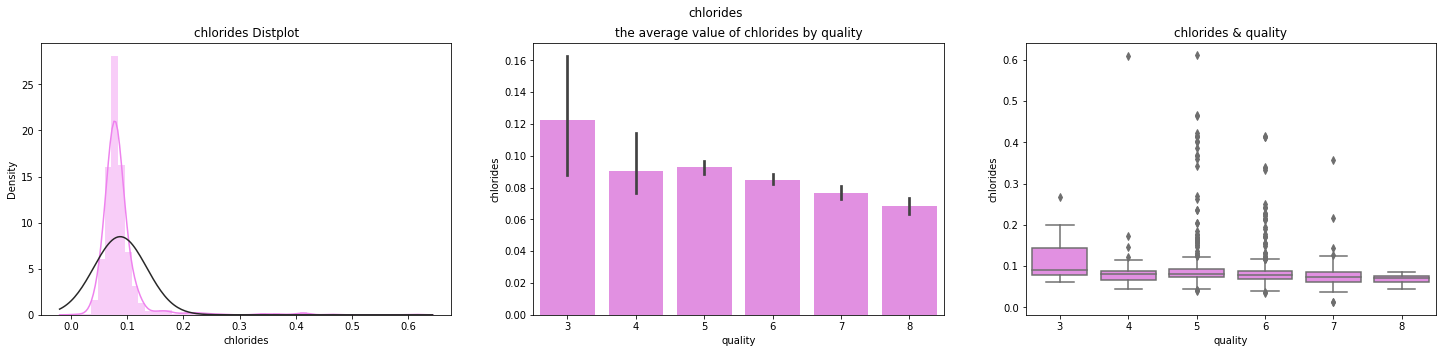

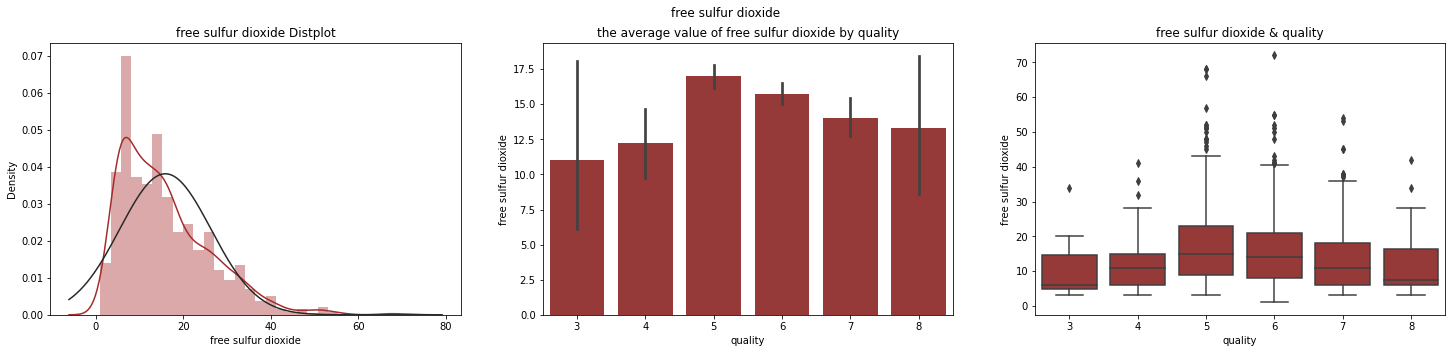

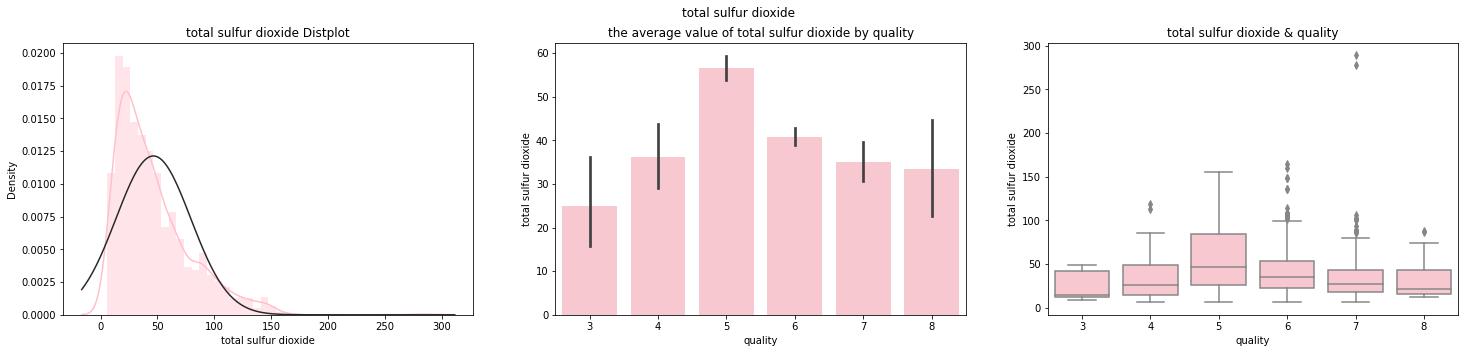

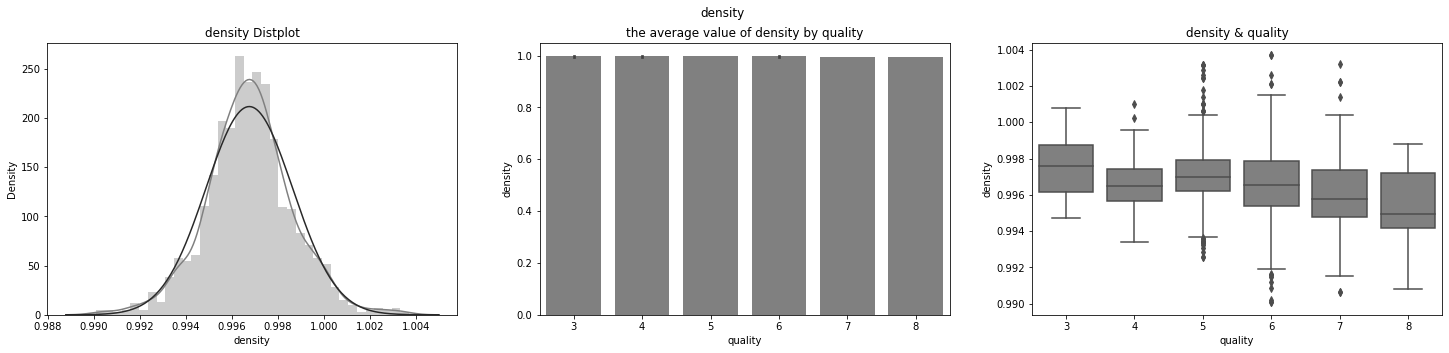

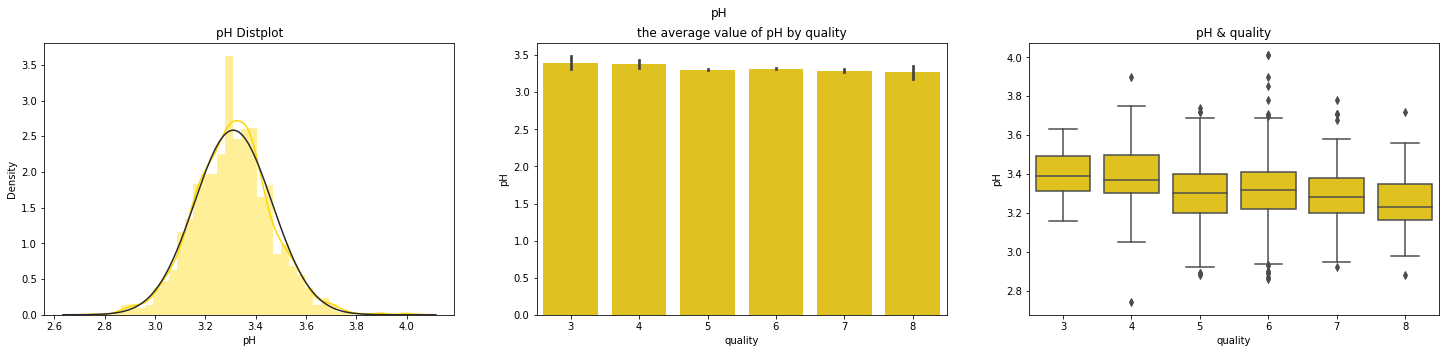

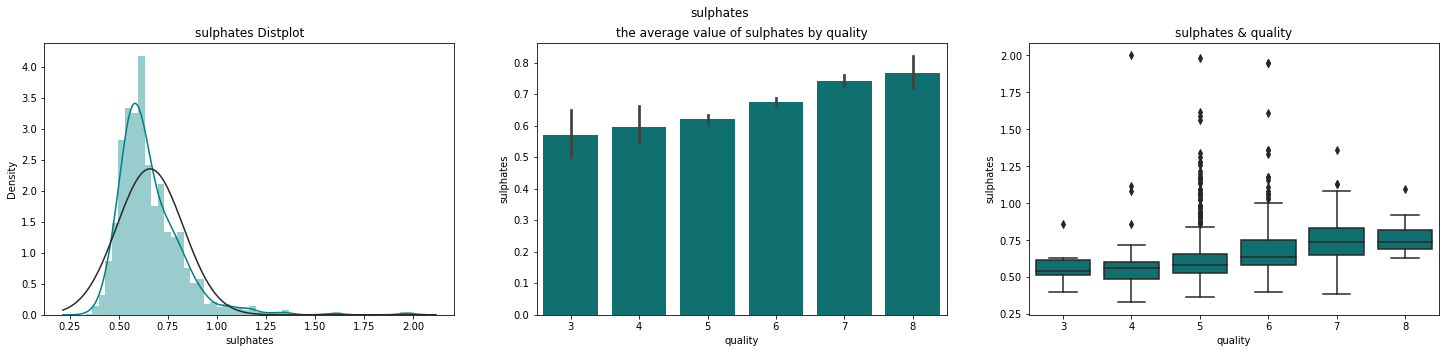

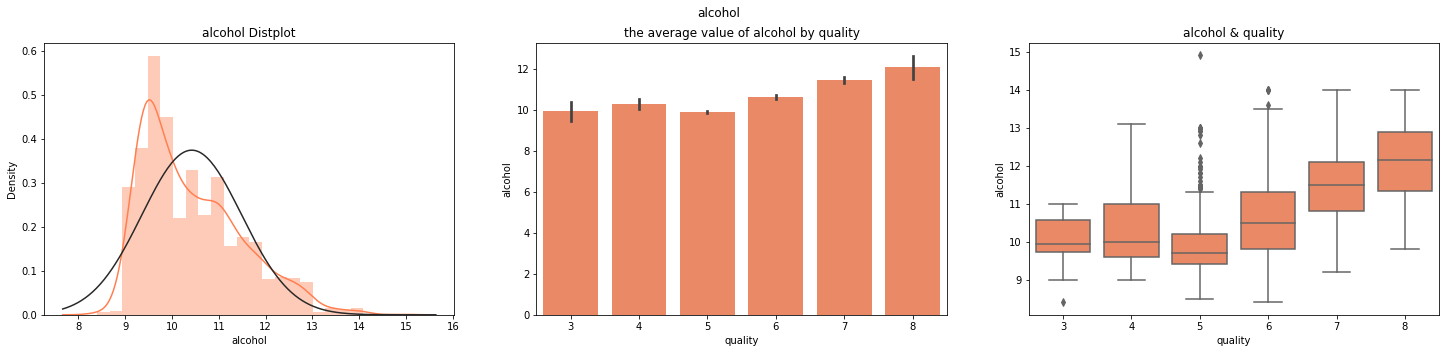

In [9]:
colors = ["dodgerblue", "orange", "green", "red", "violet", "brown", "pink", "grey", "gold", "teal", "coral"]

for column, color in zip(df.columns[:-1], colors):
    plt.figure(figsize=[25, 5])

    plt.subplot(1, 3, 1)
    sns.distplot(df[column], fit=norm, color=color)
    plt.title(f"{column} Distplot")
    plt.subplot(1, 3, 2)
    sns.barplot(x = df["quality"], y = df[column], color=color)
    plt.title(f"the average value of {column} by quality")
    plt.subplot(1, 3, 3)
    sns.boxplot(df['quality'], df[column], color=color)
    plt.title(f"{column} & quality")
    plt.suptitle(column)
    if save:
        c = column.replace(" ", "_")
        plt.savefig(f"figures/{c}_plots.jpeg", bbox_inches="tight")
    
plt.show()

Some conclusions:

1. **fixed acidity**: does not seem to affect the quality as much sense the bars don't appear to have any pattern
2. **volatile acidity**: from the average values of volatile acidity by quality, we can say that the decrease in volatile acidity seems to affect the quality positively
3. **citric acid**: the increase in citric acid seems to affect the quality positively
4. **residual sugar**: does not seem to affect the quality as much sense the bars don't appear to have any pattern
5. **chlorides**: the decrease in chlorides seems to affect the quality positively
6. **free sulfur dioxide**: Examining the average values of free sulfur dioxide by quality we cant really see that they have the free sulfur dioxide has a regular effect on the quality
7. **total sulfur dioxide**: Examining the average values of total sulfur dioxide by quality we cant really see if they have a regular effect on the quality
8. **density**: Given on how similar the average values of density by quality are we can say that density does not have much effect on the quality. Very close to a normal distribution
9. **ph**: We can see that the slight decrease on ph levels has a positive effect on quality. Also, very close to a normal distribution
10. **sulphates**: The higher the value of sulphates the more positive the quality is
11. **alcohol sulfur dioxide**: The increase on alcohol sulfur dioxide has a positive effect on quality

Overall, almost every column has a lot of outliers expect **citric acid**

---

### Data preprocessing

Next up, we are going to delete the outliers. <br>
In order to detect the outliers we are going to use the **Interquartile range rule** ($1.5 \times IQR$) <br>
We decided to delete a row if it has at least 2 outliers

In [10]:
outlier_indices = []

for feature in df.columns[:-1]:
    Q1 = np.percentile(df[feature], 25)
    Q3 = np.percentile(df[feature], 75)

    IQR = Q3 - Q1
    outlier_step = IQR * 1.5

    outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)

In [11]:
outlier_indices_counter = {}
for i in outlier_indices:
  if i in outlier_indices_counter:
    outlier_indices_counter[i] += 1
  else:
    outlier_indices_counter[i] = 1

In [12]:
rows_to_exclude = [k for k, v in outlier_indices_counter.items() if v >= 2]

In [13]:
print(f"Found {len(rows_to_exclude)} rows with 2 or more outliers")

Found 120 rows with 2 or more outliers


In [14]:
df.drop(rows_to_exclude, axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1474,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1475,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1476,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1477,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [15]:
print(f"{len(df)} rows remaining")

1479 rows remaining


Now we are going to aggregate the 11 classes (possible values of quality) into only 2: good wine = 1 or bad wine = 0 <br>
The goal is to balance the dataset transform this problem into binary classification

In [16]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [17]:
df.loc[df["quality"].isin([3, 4, 5]), "quality"] = 0
df.loc[df["quality"].isin([6, 7, 8]), "quality"] = 1

In [18]:
df["quality"].unique()

array([0, 1], dtype=int64)

In [19]:
quality_counts = df.groupby("quality").quality.count()
quality_counts

quality
0    678
1    801
Name: quality, dtype: int64

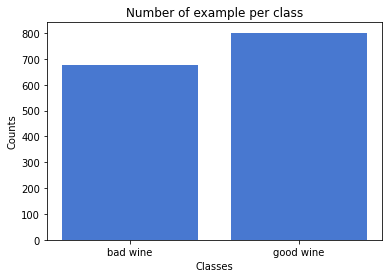

In [21]:
plt.bar(x = quality_counts.index, height=quality_counts.values)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Number of example per class")
plt.xticks([0, 1])
locs, labels = plt.xticks()
plt.xticks(locs, ["bad wine", "good wine"])
plt.savefig("figures/wine_quality_binary_distribution.jpeg", bbox_inches="tight") if save else plt.show()

As we can see the number of examples per class are much closer <br>

let's split the train and test data and making the quality of the wine the target variable

In [21]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [23]:
print(f"""
X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}
""")


X_train: (1183, 11)
y_train: (1183,)
X_test: (296, 11)
y_test: (296,)



Scaling the data

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

---

### Training and Testing Classifiers

The classifiers we are going to use are:
1. Logistic Regression (LR)
2. Decision Tree Classifier (DTC)
3. Random Forest Classifier (RFC)
4. Support Vector Classifier (SVC)
5. K Neighbors Classifier (KNC)
6. Gaussian NB (GNB)
7. Neural Network (NN)

We are going to use sklearn's **GridSearchCV** to exhaustively search for the best parameters to tune our models <br>
We also opted for 5 folds on the CV

In [25]:
models_best_results = []
models_results = []
models_best_parameters = {}
cv = 5

---

#### Logistic Regression

In [26]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [27]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.699248,0.756098,0.726563,123.000000
1,0.815951,0.768786,0.791667,173.000000
accuracy,0.763514,0.763514,0.763514,0.763514
macro avg,0.757600,0.762442,0.759115,296.000000
weighted avg,0.767456,0.763514,0.764613,296.000000


In [28]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,93,30
1,40,133


In [29]:
gscv = GridSearchCV(estimator=lr, param_grid={"C": [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]}, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .............................C=0.1;, score=0.768 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.751 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.717 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.746 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.733 total time=   0.0s
[CV 1/5] END .............................C=0.8;, score=0.764 total time=   0.0s
[CV 2/5] END .............................C=0.8;, score=0.747 total time=   0.0s
[CV 3/5] END .............................C=0.8;, score=0.717 total time=   0.0s
[CV 4/5] END .............................C=0.8;, score=0.750 total time=   0.0s
[CV 5/5] END .............................C=0.8;, score=0.733 total time=   0.0s
[CV 1/5] END .............................C=0.9;, score=0.764 total time=   0.0s
[CV 2/5] END .............................C=0.9;,

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]},
             scoring='accuracy', verbose=3)

In [30]:
models_best_parameters["lr"] = gscv.best_params_
gscv.best_params_

{'C': 1.3}

In [31]:
lr = LogisticRegression(C = gscv.best_params_["C"], random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [32]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/lr_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.699248,0.756098,0.726563,123.000000
1,0.815951,0.768786,0.791667,173.000000
accuracy,0.763514,0.763514,0.763514,0.763514
macro avg,0.757600,0.762442,0.759115,296.000000
weighted avg,0.767456,0.763514,0.764613,296.000000


In [33]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/lr_cm_cv_{cv}.csv")
cm

,0,1
0,93,30
1,40,133


In [34]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### Decision Tree Classifier

In [35]:
dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [36]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.650350,0.756098,0.699248,123.00000
1,0.803922,0.710983,0.754601,173.00000
accuracy,0.729730,0.729730,0.729730,0.72973
macro avg,0.727136,0.733540,0.726925,296.00000
weighted avg,0.740106,0.729730,0.731600,296.00000


In [37]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,93,30
1,50,123


In [38]:
params = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_depth" : np.arange(1, 11)
}

In [39]:
gscv = GridSearchCV(estimator=dtc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END criterion=gini, max_depth=1, splitter=best;, score=0.692 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, splitter=best;, score=0.709 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, splitter=best;, score=0.662 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, splitter=best;, score=0.682 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, splitter=best;, score=0.669 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, splitter=random;, score=0.738 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, splitter=random;, score=0.709 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, splitter=random;, score=0.692 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, splitter=random;, score=0.682 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, splitter=random;, score=0.669 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [40]:
models_best_parameters["dtc"] = gscv.best_params_
gscv.best_params_

{'criterion': 'gini', 'max_depth': 8, 'splitter': 'random'}

In [41]:
dtc = DecisionTreeClassifier(criterion=gscv.best_params_["criterion"], max_depth=gscv.best_params_["max_depth"], splitter=gscv.best_params_["splitter"], random_state = 42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [42]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/dtc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.662069,0.780488,0.716418,123.000000
1,0.821192,0.716763,0.765432,173.000000
accuracy,0.743243,0.743243,0.743243,0.743243
macro avg,0.741631,0.748625,0.740925,296.000000
weighted avg,0.755070,0.743243,0.745065,296.000000


In [43]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/dtc_cm_cv_{cv}.csv")
cm

,0,1
0,96,27
1,49,124


In [44]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### Random Forest Classifier

In [45]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [46]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.770370,0.845528,0.806202,123.000000
1,0.881988,0.820809,0.850299,173.000000
accuracy,0.831081,0.831081,0.831081,0.831081
macro avg,0.826179,0.833169,0.828250,296.000000
weighted avg,0.835606,0.831081,0.831975,296.000000


In [47]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,104,19
1,31,142


In [48]:
params = {
    "n_estimators" : np.arange(50, 550, 50),
    "criterion" : ["gini", "entropy"],
    "max_depth" : np.arange(1, 11),
}

In [49]:
gscv = GridSearchCV(estimator=rfc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.743 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.726 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.709 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.716 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, n_estimators=50;, score=0.703 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.759 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.734 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.713 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.729 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=1, n_estimators=100;, score=0.703 total time=   0.4s
[CV 1/5] END criterio

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
             scoring='accuracy', verbose=3)

In [50]:
models_best_parameters["rfc"] = gscv.best_params_
gscv.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 350}

In [51]:
rfc = RandomForestClassifier(n_estimators=gscv.best_params_["n_estimators"], criterion=gscv.best_params_["criterion"], max_depth=gscv.best_params_["max_depth"], random_state = 42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [52]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/rfc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.744681,0.853659,0.795455,123.000000
1,0.883871,0.791908,0.835366,173.000000
accuracy,0.817568,0.817568,0.817568,0.817568
macro avg,0.814276,0.822783,0.815410,296.000000
weighted avg,0.826032,0.817568,0.818781,296.000000


In [53]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/rfc_cm_cv_{cv}.csv")
cm

,0,1
0,105,18
1,36,137


In [54]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### Support Vector Classifier

In [55]:
svc = SVC(random_state = 42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [56]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.685315,0.796748,0.736842,123.000000
1,0.836601,0.739884,0.785276,173.000000
accuracy,0.763514,0.763514,0.763514,0.763514
macro avg,0.760958,0.768316,0.761059,296.000000
weighted avg,0.773736,0.763514,0.765150,296.000000


In [57]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,98,25
1,45,128


In [58]:
params = {
    'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]
}

In [59]:
gscv = GridSearchCV(estimator=svc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.751 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.751 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.709 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.729 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.759 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.747 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.730 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.742 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.8, kernel=linear;, score=0.751 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.8, kernel=linea

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [60]:
models_best_parameters["svc"] = gscv.best_params_
gscv.best_params_

{'C': 1.1, 'gamma': 0.8, 'kernel': 'rbf'}

In [61]:
svc = SVC(C = gscv.best_params_["C"], kernel = gscv.best_params_["kernel"], gamma = gscv.best_params_["gamma"], random_state = 42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [62]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/scv_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.752066,0.739837,0.745902,123.000000
1,0.817143,0.826590,0.821839,173.000000
accuracy,0.790541,0.790541,0.790541,0.790541
macro avg,0.784604,0.783213,0.783870,296.000000
weighted avg,0.790101,0.790541,0.790284,296.000000


In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/svc_cm_cv_{cv}.csv")
cm

,0,1
0,91,32
1,30,143


In [64]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### K Neighbours Classifier

In [65]:
knc = KNeighborsClassifier()

In [66]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

In [67]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.697674,0.731707,0.714286,123.000000
1,0.802395,0.774566,0.788235,173.000000
accuracy,0.756757,0.756757,0.756757,0.756757
macro avg,0.750035,0.753137,0.751261,296.000000
weighted avg,0.758879,0.756757,0.757506,296.000000


In [68]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,90,33
1,39,134


In [69]:
params = {
    "n_neighbors" : np.arange(1, 11),
    "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"]
}

In [70]:
gscv = GridSearchCV(estimator=knc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END .....algorithm=auto, n_neighbors=1;, score=0.730 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=1;, score=0.785 total time=   0.0s
[CV 3/5] END .....algorithm=auto, n_neighbors=1;, score=0.734 total time=   0.0s
[CV 4/5] END .....algorithm=auto, n_neighbors=1;, score=0.703 total time=   0.0s
[CV 5/5] END .....algorithm=auto, n_neighbors=1;, score=0.703 total time=   0.0s
[CV 1/5] END .....algorithm=auto, n_neighbors=2;, score=0.679 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=2;, score=0.717 total time=   0.0s
[CV 3/5] END .....algorithm=auto, n_neighbors=2;, score=0.688 total time=   0.0s
[CV 4/5] END .....algorithm=auto, n_neighbors=2;, score=0.691 total time=   0.0s
[CV 5/5] END .....algorithm=auto, n_neighbors=2;, score=0.678 total time=   0.0s
[CV 1/5] END .....algorithm=auto, n_neighbors=3;, score=0.705 total time=   0.0s
[CV 2/5] END .....algorithm=auto, n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy', verbose=3)

In [71]:
models_best_parameters["knc"] = gscv.best_params_
gscv.best_params_

{'algorithm': 'auto', 'n_neighbors': 9}

In [72]:
knc = KNeighborsClassifier(n_neighbors = gscv.best_params_["n_neighbors"], algorithm = gscv.best_params_["algorithm"])
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

In [73]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/knc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.696000,0.707317,0.701613,123.00
1,0.789474,0.780347,0.784884,173.00
accuracy,0.750000,0.750000,0.750000,0.75
macro avg,0.742737,0.743832,0.743248,296.00
weighted avg,0.750632,0.750000,0.750281,296.00


In [74]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/knc_cm_cv_{cv}.csv")
cm

,0,1
0,87,36
1,38,135


In [75]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### GaussianNB

In [76]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [77]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])
df_report

,precision,recall,f1-score,support
0,0.664384,0.788618,0.721190,123.000000
1,0.826667,0.716763,0.767802,173.000000
accuracy,0.746622,0.746622,0.746622,0.746622
macro avg,0.745525,0.752690,0.744496,296.000000
weighted avg,0.759231,0.746622,0.748433,296.000000


In [78]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,97,26
1,49,124


In [79]:
params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [80]:
gscv = GridSearchCV(estimator=gnb, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.793 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.730 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.713 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.733 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.682 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.793 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.726 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.713 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.733 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.682 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.793 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=3)

In [81]:
models_best_parameters["gnb"] = gscv.best_params_
gscv.best_params_

{'var_smoothing': 1.0}

In [82]:
gnb = GaussianNB(var_smoothing = gscv.best_params_["var_smoothing"])
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [83]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv(f"tables/gnc_report_cv_{cv}.csv")
df_report

,precision,recall,f1-score,support
0,0.664474,0.821138,0.734545,123.000000
1,0.847222,0.705202,0.769716,173.000000
accuracy,0.753378,0.753378,0.753378,0.753378
macro avg,0.755848,0.763170,0.752131,296.000000
weighted avg,0.771283,0.753378,0.755101,296.000000


In [84]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
if save:
    cm.to_csv(f"tables/gnb_cm_cv_{cv}.csv")
cm

,0,1
0,101,22
1,51,122


In [85]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred)])

---

#### Neural Network

In [86]:
def get_model(number_of_features, number_of_outputs):
    inputs = Input(shape=(number_of_features,))

    l = Dense(5, activation='relu')(inputs)

    outputs = Dense(number_of_outputs, activation='sigmoid')(l)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy']) 
    return model

In [87]:
nn = get_model(X_train.shape[1], 1)
nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 5)                 60        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = nn.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 32)

Epoch 1/50
37/37 [==============================] - 1s 8ms/step - loss: 0.8049 - accuracy: 0.5376 - val_loss: 0.7317 - val_accuracy: 0.5777
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.7513 - accuracy: 0.5596 - val_loss: 0.6885 - val_accuracy: 0.5980
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7130 - accuracy: 0.5850 - val_loss: 0.6581 - val_accuracy: 0.6115
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5968 - val_loss: 0.6359 - val_accuracy: 0.6486
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6643 - accuracy: 0.6171 - val_loss: 0.6193 - val_accuracy: 0.6622
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6281 - val_loss: 0.6061 - val_accuracy: 0.6689
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6424 - val_loss: 0.5941 - val_accuracy: 0.6824
Epoch 8/50
37/37 [==

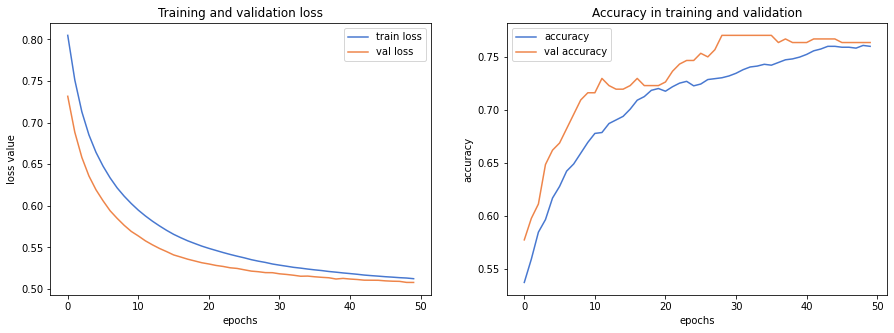

In [95]:
history_df = pd.DataFrame(history.history)
plt.figure(0, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.loss, label="train loss")
plt.plot(history_df.val_loss, label="val loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(history_df.accuracy, label="accuracy")
plt.plot(history_df.val_accuracy, label="val accuracy")
plt.title("Accuracy in training and validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.savefig("figures/nn_loss_accuracy.jpeg", bbox_inches="tight") if save else plt.show()

In [90]:
models_best_parameters["nn"] = {"input_layer": "(-1, 11)", "hidden_layers": "Dense(5)", "output_layers":"Dense(1, activation = sigmoid)"}

In [91]:
y_pred = nn.predict(X_test)
y_pred_coded = [1 if x >= 0.5 else 0 for x in y_pred]

In [92]:
report = classification_report(y_test, y_pred_coded, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if save:
    df_report.to_csv("tables/nn_report.csv")
df_report

,precision,recall,f1-score,support
0,0.690647,0.780488,0.732824,123.000000
1,0.828025,0.751445,0.787879,173.000000
accuracy,0.763514,0.763514,0.763514,0.763514
macro avg,0.759336,0.765966,0.760352,296.000000
weighted avg,0.770939,0.763514,0.765001,296.000000


In [93]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_coded))
if save:
    cm.to_csv("tables/nn_cm.csv")
cm

,0,1
0,96,27
1,43,130


In [97]:
models_best_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred_coded)])
models_results.append(list(df_report.iloc[0, :-1].values) + [accuracy_score(y_test, y_pred_coded)])

---

### Final results

Models bets parameters

In [98]:
models_best_parameters

{'dtc': {'criterion': 'gini', 'max_depth': 8, 'splitter': 'random'},
 'gnb': {'var_smoothing': 1.0},
 'knc': {'algorithm': 'auto', 'n_neighbors': 9},
 'lr': {'C': 1.3},
 'nn': {'hidden_layers': 'Dense(5)',
  'input_layer': '(-1, 11)',
  'output_layers': 'Dense(1, activation = sigmoid)'},
 'rfc': {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 350},
 'svc': {'C': 1.1, 'gamma': 0.8, 'kernel': 'rbf'}}

The results of the models before using GridSearchCV

In [99]:
df_results = pd.DataFrame(models_results, columns = ["precision", "recall", "f1-score", "accuracy"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB", "NN"])
df_results = df_results.round(3)
df_results = df_results * 100
if save:
  df_results.to_csv(f"tables/all_models_results_cv_{cv}.csv")
df_results

,precision,recall,f1-score,accuracy
LR,69.9,75.6,72.7,76.4
DTC,65.0,75.6,69.9,73.0
RFC,77.0,84.6,80.6,83.1
SVC,68.5,79.7,73.7,76.4
KNC,69.8,73.2,71.4,75.7
GNB,66.4,78.9,72.1,74.7
NN,69.1,78.0,73.3,76.4


The results of the models after using GridSearchCV

In [107]:
df_best_results = pd.DataFrame(models_best_results, columns = ["precision", "recall", "f1-score", "accuracy"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB", "NN"])
df_best_results = df_best_results.round(3)
df_best_results = df_best_results * 100
if save:
  df_best_results.to_csv(f"tables/all_models_best_results_cv_{cv}.csv")
df_best_results

,precision,recall,f1-score,accuracy
LR,69.9,75.6,72.7,76.4
DTC,66.2,78.0,71.6,74.3
RFC,74.5,85.4,79.5,81.8
SVC,75.2,74.0,74.6,79.1
KNC,69.6,70.7,70.2,75.0
GNB,66.4,82.1,73.5,75.3
NN,69.1,78.0,73.3,76.4


Comparison between before and after using GridSearchCV <br>
Column names with "*_CV*" in the name are the results after the GridSearchCV

In [108]:
results_comparison = [[result[0], best_result[0], result[1], best_result[1], result[2], best_result[2], result[3], best_result[3]] for result, best_result in zip(models_results, models_best_results)]

In [109]:
df_results_comparison = pd.DataFrame(results_comparison, columns = ["precision", "precision_CV", "recall", "recall_CV", "f1-score", "f1-score_CV", "accuracy", "accuracy_CV"], index = ["LR", "DTC", "RFC", "SVC", "KNC", "GNB", "NN"])
df_results_comparison = df_results_comparison.round(3)
df_results_comparison = df_results_comparison * 100
if save:
  df_results_comparison.to_csv(f"tables/results_comparison_cv_{cv}.csv")
df_results_comparison

,precision,precision_CV,recall,recall_CV,f1-score,f1-score_CV,accuracy,accuracy_CV
LR,69.9,69.9,75.6,75.6,72.7,72.7,76.4,76.4
DTC,65.0,66.2,75.6,78.0,69.9,71.6,73.0,74.3
RFC,77.0,74.5,84.6,85.4,80.6,79.5,83.1,81.8
SVC,68.5,75.2,79.7,74.0,73.7,74.6,76.4,79.1
KNC,69.8,69.6,73.2,70.7,71.4,70.2,75.7,75.0
GNB,66.4,66.4,78.9,82.1,72.1,73.5,74.7,75.3
NN,69.1,69.1,78.0,78.0,73.3,73.3,76.4,76.4
